In [10]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader,Dataset


DAYS_FOR_TRAIN = 3
FEATURE_SIZE = 10
BATCH_SIZE = 32
TEST_SIZE = 0.3
DROPOUT_PROB = 0

with_sent = True

# selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30]
if with_sent:
    selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30] # with sent
else:
    selected_ft = [1, 2, 3, 4, 5, 57, 26, 42, 19, 32, 33, 25, 15, 17, 14, 24, 67, 88, 43, 58, 18, 60, 36, 66, 28] 
    
selected_ft = selected_ft[:FEATURE_SIZE]



In [2]:
def my_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(extend_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


class StockDataset(Dataset):
    """stock market dataset"""
    
    def __init__(self, dataset, days_for_train=5, feature_size=5, scaled=True, scaler=None):
        self.days_for_train = days_for_train
        self.feature_size = feature_size
        self.ori_data = dataset

        self.data = self.ori_data.iloc[:, selected_ft].values.astype(np.float32)
#         print(self.data)
        if scaled:
            if scaler is None:
                self.scaler = MinMaxScaler()
                self.data = self.scaler.fit_transform(self.data).astype(np.float32)
            else:
                self.data = scaler.transform(self.data).astype(np.float32)
                self.scaler = scaler
        
        self.x = self.data
        self.y = self.data[:, 3]
        
        

    def __len__(self):
        return self.data.shape[0] - self.days_for_train

    
    def __getitem__(self, idx):
        x = self.x[idx:idx+self.days_for_train]
        y = np.zeros((1), dtype=np.float32)

        y[0] = self.y[idx+self.days_for_train]

        t_x = torch.from_numpy(x)
        t_y = torch.from_numpy(y)
        return t_x, t_y
    
    def get_scaler(self):
        return self.scaler


class BaseLSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)

    def forward(self, _x):
        out0 = self.fc0(_x)
        x, _ = self.lstm(out0)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        out1 = self.fc(x)
        out1 = out1.view(s, b)  # 把形状改回来
        out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
        out2 = self.fc2(out1)
        # print(out2.shape)
        # out2 = out2.view(b, -1)
        return out2
    

class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

#         self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)
#         self.out_fc = nn.Linear()

        self.dropout = nn.Dropout(DROPOUT_PROB)

        
    def attention_net(self, x, query, mask=None):
        d_k = query.size(-1)
        
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)
        
        alpha_n = F.softmax(scores, dim=-1)
        
        context = torch.matmul(alpha_n, x).sum(1)
        
        return context, alpha_n
        
        
    def forward(self, _x):
#         out0 = self.fc0(_x)
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
#         print(x.shape)
        x = x.permute(1, 0, 2)
#         print(x.shape)
        query = self.dropout(x)
        x, _ = self.attention_net(x, query)
    
#         print(x.shape)
#         s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        
        
#         x = x.view(s*b, h)
        out1 = self.fc(x)
#         out1 = out1.view(s, b)  # 把形状改回来
#         out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
#         out2 = self.fc2(out1)
        # print(out2.shape)
        return out1
    

def my_train(train_dataset):
#     print(train_dataset)
    data = StockDataset(train_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE)
    D = DataLoader(dataset=data, batch_size=BATCH_SIZE)

    model = LSTM_Regression(FEATURE_SIZE, 8, output_size=1, num_layers=2)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(700):       
        for i, (x, y) in enumerate(D):
#             print(x.shape, y.shape)
            x = x.transpose(0, 1)
#             x.transpose(1, 2)
            pred_y = model(x)
#             print('pred_y: ', pred_y.shape)
            loss = loss_function(pred_y, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # out = model(train_x)
        # loss = loss_function(out, train_y)

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

        if (epoch+1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))
    
    return model, data.scaler


In [3]:
def my_test(model, test_dataset, train_scaler, output_file):
    model.eval()
    loss_function = nn.MSELoss()

    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
    test_D = DataLoader(dataset=test_data, batch_size=1)

    all_rmse = []
    all_mae = []
    preds = []
    targets = []
    
    ori_preds = []
    ori_targets = []
    

    for i, (test_x, test_y) in enumerate(test_D):
        test_x = test_x.transpose(0, 1)
#         test_x = test_x.to(device)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
#         pred_y = pred_y.cpu()
        tmp_pred_y = pred_y.detach().numpy()[0][0]
        tmp_test_y = test_y.detach().numpy()[0][0]
        
#         print(tmp_pred_y)
        preds.append(tmp_pred_y)
        targets.append(tmp_test_y)
        
        ori_test_y = (tmp_test_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        ori_pred_y = (tmp_pred_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        
        
        ori_preds.append(ori_pred_y)
        ori_targets.append(ori_test_y)

#         rmse = loss_function(test_y, pred_y)
#         all_rmse.append(rmse)
        
#         mae = mean_absolute_error(tmp_test_y, tmp_pred_y)
#         all_mae.append(mae)
    
#         print(test_loss)

    print('mse: %.5f' % (mean_squared_error(targets, preds)))
    print('ori mse: %.5f' % (mean_squared_error(ori_targets, ori_preds)))
    
    print('ori mae: %.5f' % (mean_absolute_error(ori_targets, ori_preds)))
    
#     print('test rmse: %.5f' % (sum(all_rmse)))
#     print('test mae: %.5f' % (sum(all_mae)))
    
    train_size = len(test_data) * (1 - TEST_SIZE)
    plt.plot(preds, 'r', label='prediction')
    plt.plot(targets, 'b', label='real')
    plt.grid()
    plt.legend()
    plt.plot((train_size, train_size), (-0.1, 1.5), 'g--')
    plt.savefig(output_file, format='png', dpi=200)
    plt.show()
    
    return ori_preds, ori_targets

In [7]:
def my_eval(comp, with_sent):
    csv_file = f'data/sentiments/{comp}_sent.csv' if with_sent else f'data/{comp}_ori.csv'
    train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
    # train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
    trained_model, train_scaler = my_train(train_dataset)

    my_test(trained_model, test_dataset, train_scaler, f'result_img/{comp}_test_result{"_sent" if with_sent else ""}.png')
    ori_preds, ori_targets = my_test(trained_model, ori_dataset, train_scaler, f'result_img/{comp}_result{"_sent" if with_sent else ""}.png')
    
    pred_df, tgt_df = data2df(ori_preds, ori_targets, ori_dataset)
    pred_df.to_csv(f'output/{comp}_pred{"_sent" if with_sent else ""}.csv', index=False)
    tgt_df.to_csv(f'output/{comp}_tgt{"_sent" if with_sent else ""}.csv', index=False)

In [8]:
def data2df(ori_preds, ori_targets, ori_dataset):
    out_preds = []
    out_tgts = []
    for i in range(len(ori_preds)):
        out_preds.append(ori_preds[i])
        out_tgts.append(ori_targets[i])

    out_preds_df = pd.DataFrame()
    out_preds_df['Date'] = ori_dataset['Date'][3:].values
    out_preds_df['Close'] = out_preds



    out_tgts_df = pd.DataFrame()
    out_tgts_df['Date'] = ori_dataset['Date'][3:].values
    out_tgts_df['Close'] = out_tgts
    
    return out_preds_df, out_tgts_df

## evaluation

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00429
Epoch: 200, Loss:0.00364
Epoch: 300, Loss:0.00301
Epoch: 400, Loss:0.00274
Epoch: 500, Loss:0.00305
Epoch: 600, Loss:0.00222
Epoch: 700, Loss:0.00246
mse: 0.00236
ori mse: 14.51784
ori mae: 2.95408


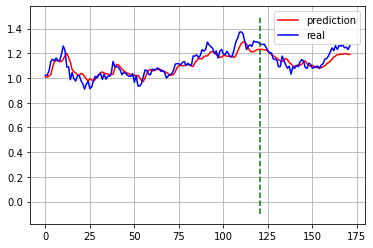

mse: 0.00103
ori mse: 6.34050
ori mae: 1.67854


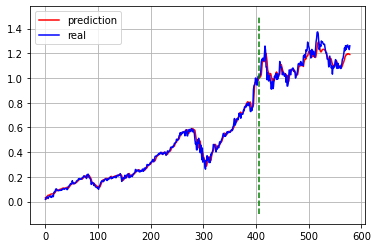

In [11]:
my_eval('aapl', with_sent)

aapl


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00469
Epoch: 200, Loss:0.00315
Epoch: 300, Loss:0.00254
Epoch: 400, Loss:0.00220
Epoch: 500, Loss:0.00179
Epoch: 600, Loss:0.00132
Epoch: 700, Loss:0.00109
mse: 0.00124
ori mse: 13.27203
ori mae: 2.87170


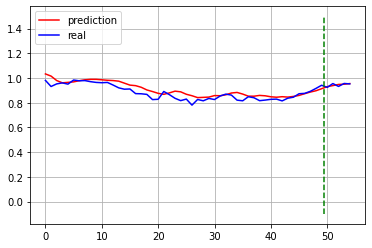

mse: 0.00061
ori mse: 6.54731
ori mae: 1.81361


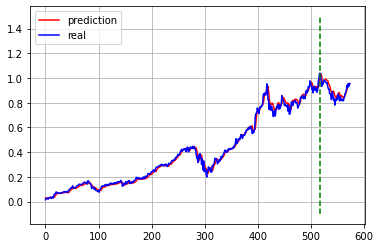

amzn


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00229
Epoch: 200, Loss:0.00217
Epoch: 300, Loss:0.00185
Epoch: 400, Loss:0.00159
Epoch: 500, Loss:0.00141
Epoch: 600, Loss:0.00148
Epoch: 700, Loss:0.00168
mse: 0.00119
ori mse: 4921.07227
ori mae: 57.38719


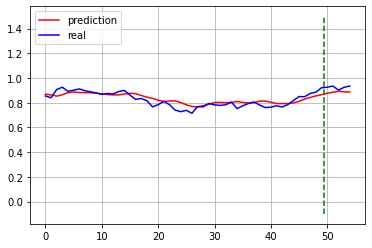

mse: 0.00082
ori mse: 3392.47266
ori mae: 42.33946


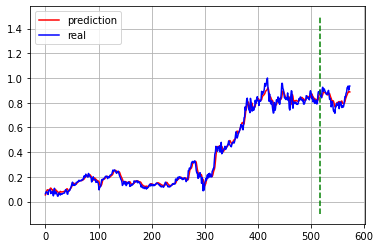

goog


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00530
Epoch: 200, Loss:0.00392
Epoch: 300, Loss:0.00320
Epoch: 400, Loss:0.00267
Epoch: 500, Loss:0.00221
Epoch: 600, Loss:0.00191
Epoch: 700, Loss:0.00171
mse: 0.00180
ori mse: 1408.07117
ori mae: 29.01791


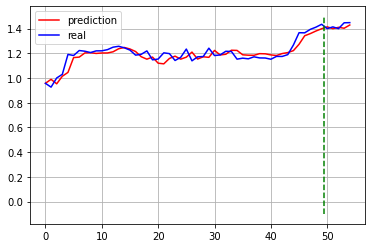

mse: 0.00096
ori mse: 750.50903
ori mae: 19.56575


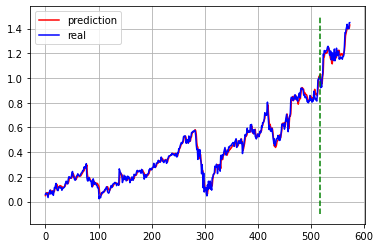

msft


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00295
Epoch: 200, Loss:0.00265
Epoch: 300, Loss:0.00231
Epoch: 400, Loss:0.00200
Epoch: 500, Loss:0.00163
Epoch: 600, Loss:0.00339
Epoch: 700, Loss:0.00255
mse: 0.00381
ori mse: 68.60694
ori mae: 6.98427


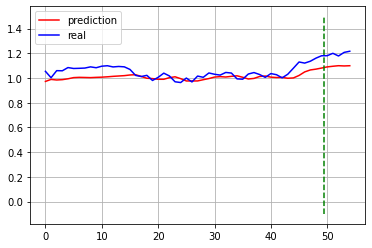

mse: 0.00171
ori mse: 30.87317
ori mae: 4.65940


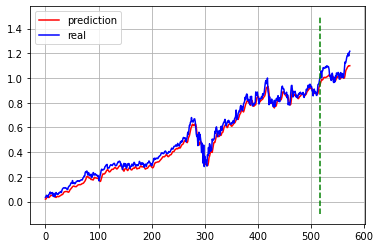

nflx


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.02338
Epoch: 200, Loss:0.01916
Epoch: 300, Loss:0.01703
Epoch: 400, Loss:0.01639
Epoch: 500, Loss:0.01482
Epoch: 600, Loss:0.01349
Epoch: 700, Loss:0.01321
mse: 0.00137
ori mse: 151.14265
ori mae: 9.53512


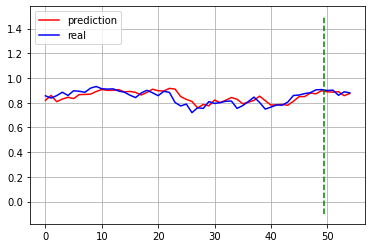

mse: 0.00124
ori mse: 136.79645
ori mae: 8.35276


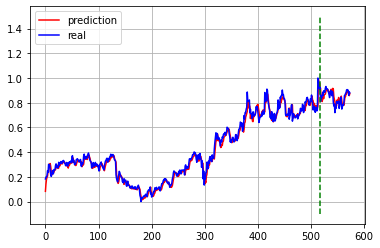

tsla


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00001
Epoch: 200, Loss:0.00167
Epoch: 300, Loss:0.00137
Epoch: 400, Loss:0.00108
Epoch: 500, Loss:0.00095
Epoch: 600, Loss:0.00087
Epoch: 700, Loss:0.00080
mse: 0.00383
ori mse: 2728.01343
ori mae: 39.87687


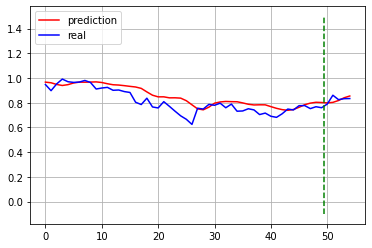

mse: 0.00077
ori mse: 546.05573
ori mae: 14.21389


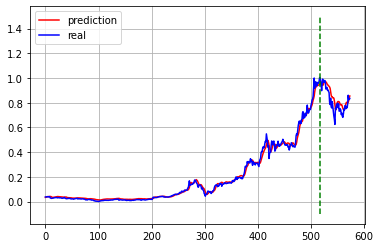

In [7]:
comps = ['aapl', 'amzn', 'goog', 'msft', 'nflx', 'tsla']

for comp in comps:
    print(comp)
    my_eval(comp, with_sent)


In [2]:
pip install xgboost

## try xgboost to select features

In [4]:
import xgboost as xgb
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

TEST_SIZE = 0.3

def xgb_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(ori_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


train_data, test_data, ori_data = xgb_load_data('data/aapl_ori.csv')

train_data = train_data.iloc[:, 1:]
train_x = train_data.iloc[:-1, 1:]
train_y = train_data.iloc[1:, 4].values

test_data = test_data.iloc[:, 1:]
test_x = test_data.iloc[:-1, 1:]
test_y = test_data.iloc[1:, 4].values

C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [5]:
data_dmatrix = xgb.DMatrix(data=train_x.values,label=train_y)
test_dmatrix = xgb.DMatrix(data=test_x.values,label=test_y)

rses = []
# for i in range(10):
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
            'max_depth': 6, 'alpha': 11, 'tree_method': 'hist', 'lambda': 0.1} 
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50, evals=[(test_dmatrix, 'errors')])
te_preds = xg_reg.predict(test_dmatrix)
rmse = np.sqrt(mean_squared_error(test_y, te_preds))
print('rmse: ', rmse)
#     rses.append((pt, rmse))
#     print(i, rmse)

[14:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	errors-rmse:113.76048
[1]	errors-rmse:105.29248
[2]	errors-rmse:97.55694
[3]	errors-rmse:90.50364
[4]	errors-rmse:83.93647
[5]	errors-rmse:78.21613
[6]	errors-rmse:71.99632
[7]	errors-rmse:66.39764
[8]	errors-rmse:62.05179
[9]	errors-rmse:58.10169
[10]	errors-rmse:53.89431
[11]	errors-rmse:50.10960
[12]	errors-rmse:46.70586
[13]	errors-rmse:43.97530
[14]	errors-rmse:41.82283
[15]	errors-rmse:39.25618
[16]	errors-rmse:36.94982
[17]	errors-rmse:35.43341
[18]	errors-rmse:33.51580
[19]	errors-rmse:32.11078
[20]	errors-rmse:30.72627
[21]	errors-rmse:29.25395
[22]	errors-rmse:28.33340
[23]	errors-rmse:27.34873
[24]	errors-rmse:26.27927
[25]	errors-rmse:25.92081
[26]	errors-rmse:25.01572
[27]	errors-rmse:24.25026
[28]	errors-rmse:23.89899
[29]	errors-rmse:23.45602
[30]	errors-rmse:22.80252
[31]	errors-rmse:22.32367

In [6]:
importances = xg_reg.get_score(importance_type='gain')
res = sorted(importances.items(), key=lambda x: -x[1])
res

[('f41', 12295.17277952),
 ('f56', 12045.0859625),
 ('f17', 9586.738191869717),
 ('f0', 8668.365852514888),
 ('f32', 3677.771972655),
 ('f1', 3167.383103566653),
 ('f14', 3159.0526271833332),
 ('f16', 2177.9734758605714),
 ('f23', 1699.51953),
 ('f87', 1198.8804217979998),
 ('f3', 1142.1256940713572),
 ('f2', 1069.4400281516666),
 ('f59', 752.7345136221248),
 ('f39', 720.0526275635),
 ('f18', 702.7642137979999),
 ('f5', 577.7471755195555),
 ('f40', 457.537854704),
 ('f25', 416.168469515),
 ('f42', 278.2756347655),
 ('f24', 173.92822265),
 ('f30', 130.93088796666666),
 ('f37', 118.03125),
 ('f57', 97.6715928075),
 ('f60', 76.4097483275),
 ('f13', 76.13641917181819),
 ('f6', 71.4609375),
 ('f80', 45.71670526666667),
 ('f50', 42.183488473999994),
 ('f35', 30.501007077),
 ('f53', 10.547668456333334),
 ('f8', 9.3216293318),
 ('f73', 7.403335578750001),
 ('f64', 7.209289555),
 ('f15', 6.289965947333333),
 ('f33', 6.2169647249999995),
 ('f45', 6.096862783333333),
 ('f65', 5.181273143333334),


In [7]:
features = [int(item[0][1:])+1 for item in res[:25]]
print(features)

[42, 57, 18, 1, 33, 2, 15, 17, 24, 88, 4, 3, 60, 40, 19, 6, 41, 26, 43, 25, 31, 38, 58, 61, 14]


In [11]:
tmp = ori_data.iloc[:, [42, 57, 18, 1, 33, 2, 15, 17, 24, 88, 4, 3, 60, 40, 19, 6, 41, 26, 43, 25, 31, 38, 58, 61, 14]]
tmp

,trend_sma_slow,trend_kst_diff,volatility_bbm,Open,volatility_dch,High,volume_nvi,volatility_atr,volatility_bbli,others_dlr,...,Volume,trend_sma_fast,volatility_kch,trend_ema_fast,volatility_kcc,volatility_kcli,trend_macd,trend_ichimoku_conv,trend_ichimoku_b,volume_vpt
0,39.480000,0.000000,39.480000,38.722500,39.712502,39.712502,1000.000000,0.000000,0.0,0.000000,...,148158800,39.480000,40.405003,39.480000,39.250000,0.0,0.000000,39.135001,39.135001,-7.591578e+07
1,37.513751,-12.129311,37.513751,35.994999,39.712502,36.430000,1000.000000,0.000000,0.0,-10.492436,...,365248800,37.513751,38.580419,38.875000,37.537917,1.0,-0.313704,37.606251,37.606251,-1.123744e+08
2,37.364167,-9.316535,37.364167,36.132500,39.712502,37.137501,1042.689302,0.000000,0.0,4.180324,...,234428400,37.364167,38.355279,38.596538,37.264445,0.0,-0.434854,37.606251,37.606251,-2.637389e+07
3,37.268749,-7.870309,37.268749,37.174999,39.712502,37.207500,1040.368435,0.000000,0.0,-0.222833,...,219111200,37.268749,38.171668,38.348225,37.170417,0.0,-0.531398,37.606251,37.606251,9.519877e+06
4,37.352500,-5.469633,37.352500,37.389999,39.712502,37.955002,1060.201109,0.000000,0.0,1.888370,...,164101200,37.352500,38.220501,38.246575,37.254500,0.0,-0.544742,37.606251,37.606251,2.640574e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,125.950000,42.773578,126.941500,133.509995,135.470001,135.470001,3676.889568,2.740313,0.0,0.505571,...,94264200,130.630833,133.888999,130.951286,131.602000,0.0,2.765556,130.305000,127.045002,2.633710e+05
578,126.414615,40.770863,127.427500,135.020004,135.529999,135.529999,3676.889568,2.838281,0.0,-1.291300,...,94812300,131.473333,134.828333,131.283396,132.317333,0.0,2.732905,132.025002,127.045002,-7.386608e+05
579,126.780384,38.828515,127.975500,132.360001,135.529999,133.750000,3687.662487,2.799453,0.0,0.292562,...,68847100,132.106667,135.381666,131.624412,132.903667,0.0,2.707291,132.500000,127.045002,-1.014725e+06
580,127.025384,34.086127,128.568000,133.039993,135.529999,134.149994,3687.662487,2.793507,0.0,-1.175419,...,84566500,132.584167,135.742999,131.672964,133.178000,0.0,2.531926,133.080002,127.045002,-7.864764e+05


In [17]:
x = [('f41', 12295.17277952),
 ('f56', 12045.0859625),
 ('f17', 9586.738191869717),
 ('f0', 8668.365852514888),
 ('f32', 3677.771972655),
 ('f1', 3167.383103566653),
 ('f14', 3159.0526271833332),
 ('f16', 2177.9734758605714),
 ('f23', 1699.51953),
 ('f87', 1198.8804217979998),
 ('f3', 1142.1256940713572),
 ('f2', 1069.4400281516666),
 ('f59', 752.7345136221248),
 ('f39', 720.0526275635),
 ('f18', 702.7642137979999),
 ('f5', 577.7471755195555),
 ('f40', 457.537854704),
 ('f25', 416.168469515),
 ('f42', 278.2756347655),
 ('f24', 173.92822265),
 ('f30', 130.93088796666666),
 ('f37', 118.03125),
 ('f57', 97.6715928075),
 ('f60', 76.4097483275),
 ('f13', 76.13641917181819)]
y = list(tmp.columns)

In [19]:
for i in range(len(x)):
    print(f'{y[i]},{x[i][1]}')

trend_sma_slow,12295.17277952
trend_kst_diff,12045.0859625
volatility_bbm,9586.738191869717
Open,8668.365852514888
volatility_dch,3677.771972655
High,3167.383103566653
volume_nvi,3159.0526271833332
volatility_atr,2177.9734758605714
volatility_bbli,1699.51953
others_dlr,1198.8804217979998
Close,1142.1256940713572
Low,1069.4400281516666
trend_ichimoku_a,752.7345136221248
trend_macd_diff,720.0526275635
volatility_bbh,702.7642137979999
Volume,577.7471755195555
trend_sma_fast,457.537854704
volatility_kch,416.168469515
trend_ema_fast,278.2756347655
volatility_kcc,173.92822265
volatility_kcli,130.93088796666666
trend_macd,118.03125
trend_ichimoku_conv,97.6715928075
trend_ichimoku_b,76.4097483275
volume_vpt,76.13641917181819
